# Solar Dynamo Model

In [1]:
from julia.api import Julia
jpath = "/Applications/Julia-1.9.app/Contents/Resources/julia/bin/julia" 

In [2]:
jl = Julia(runtime=jpath, compiled_modules=False) 

In [3]:
import julia 

In [4]:
from julia import Pkg

In [5]:
Pkg.activate("/Users/Carlo/sbi/SolarDynamoModel")

  Activating project at `~/sbi/SolarDynamoModel`


In [6]:
from julia import SolarDynamoModel


┌ Warning: AES-NI is not enabled, so AESNI and ARS are not available.
└ @ Random123 ~/.julia/packages/Random123/u5oEp/src/Random123.jl:55


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [10]:

from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

seed = 0
torch.manual_seed(seed)

In [11]:
sn = SolarDynamoModel.sn([1., 1., 5., 0.1, 10., 0.1, 0.]) #τ, T, Nd, sigma, Bmax, eps, phi 

In [26]:
num_dim = 7
low = [1.0, 1.0, 1.0, 0.01, 1.0, 0.0, 0.0]
high = [100.0, 10.0, 10.0, 0.5, 10.0, 1.0, 6.2]

prior = utils.BoxUniform(low=low, high=high)

In [17]:
SolarDynamoModel.sn([100.0, 10.0, 10.0, 0.5, 10.0, 1.0, 6.2])

array([8.23570344e+00, 8.49937194e+00, 8.75446368e+00, 8.99485209e+00,
       9.21883207e+00, 9.42311510e+00, 9.60847894e+00, 9.76880514e+00,
       9.90011110e+00, 1.00116739e+01, 1.01033425e+01, 1.01763317e+01,
       1.02298053e+01, 1.02658839e+01, 1.02800777e+01, 1.02738824e+01,
       1.02488503e+01, 1.02033372e+01, 1.01359485e+01, 1.00383005e+01,
       9.91503324e+00, 9.77380438e+00, 9.61557715e+00, 9.44101984e+00,
       9.25310684e+00, 9.05221452e+00, 8.83751993e+00, 8.60887046e+00,
       8.36410785e+00, 8.10426070e+00, 7.83388011e+00, 7.55372727e+00,
       7.26021053e+00, 6.96120686e+00, 6.65718536e+00, 6.34705336e+00,
       6.03419517e+00, 5.71939033e+00, 5.40409462e+00, 5.09146804e+00,
       4.78035831e+00, 4.47039151e+00, 4.16570165e+00, 3.85857929e+00,
       3.55431314e+00, 3.26157588e+00, 2.98008740e+00, 2.70811639e+00,
       2.44474075e+00, 2.19146719e+00, 1.94812250e+00, 1.71514888e+00,
       1.49488987e+00, 1.29032527e+00, 1.10277309e+00, 9.26688410e-01,
      

In [21]:
from sbi.utils.user_input_checks import process_simulator


simulator = process_simulator(SolarDynamoModel.sn,prior,1)

In [22]:
from sbi.utils.user_input_checks import process_prior


prior = process_prior(prior)

In [31]:
input_size = 929
num_classes = 3

class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1D convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Maxpool layer
        self.pool = nn.MaxPool1d(kernel_size=10, stride = 10)
        # Fully connected layer
        self.fc = nn.Linear(in_features=6 * (input_size // 10), out_features=num_classes)

    def forward(self, x):
        # Assuming x is of shape (batch_size, 1, input_size)
        x =x.view(-1,1,input_size)
        x = self.conv1(x)
        x = self.pool(x)
        # Flatten the output before passing it to the fully connected layer
        x = x.view(-1,6*(input_size // 10))
        x = self.fc(x)
        return x

embedding_net = SummaryNet()


In [32]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [29]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

In [33]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 391 epochs.

In [37]:
posterior = inference.build_posterior(density_estimator)

In [34]:
x_o = SolarDynamoModel.sn([10,5,5,0.1,5,0.1,3])

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/szsYq/src/performance_warnings.jl:32


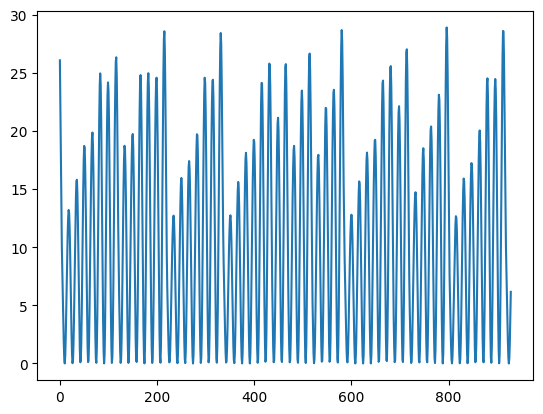

In [35]:
plt.plot(x_o)

In [40]:
low, high

([1.0, 1.0, 1.0, 0.01, 1.0, 0.0, 0.0],
 [100.0, 10.0, 10.0, 0.5, 10.0, 1.0, 6.2])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

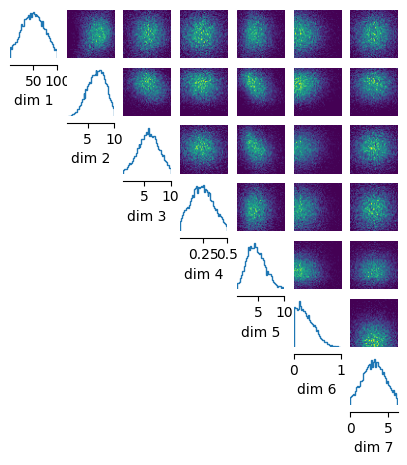

In [42]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[1.0,100.0],[1.0,10.0],[1,10],[0.01,0.5],[1,10],[0,1],[0,6.2]], figsize=(5, 5)
)